In [1]:
# dataframes 
import numpy as np
# import pandas as pd
import polars as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# tensorflow
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-01-02 16:15:12.806809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 16:15:19.404345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tomilee/miniconda3/envs/tf/lib/
2024-01-02 16:15:19.404954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tomilee/miniconda3/envs/tf/lib/
2024-01-02 16:15:19.404994: W tensorflow/compiler/tf

Num GPUs Available:  1


2024-01-02 16:15:21.528201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 16:15:21.831147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 16:15:21.831431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml_after_cut.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:01<00:03,  1.98it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  2.19it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:02<00:01,  2.19it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:02<00:00,  2.23it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:03<00:00,  2.27it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:14<00:00,  1.61s/it]


njet30          mjj      detajj  \
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603   
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb  \
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486   
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta  \
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121   
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt  \
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000   
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

In [4]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all_cut
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,471.740875,1.960242,2.980181,491.291687,178915.984375,1.259632,-2.167910,3.411552e+05,133583.312500,3.219874,1.135094,1.674184e+06,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,45681.097656,3.302509,-0.662832,6.216837e+05,35162.062500,2.523157,2.545976,2.206442e+05,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,40501.546875,1.277558,-3.141293,7.845353e+04,33459.644531,0.984051,-0.838438,5.148936e+04,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,152246.031250,1.397108,1.148800,3.269545e+05,144588.734375,-0.855398,-2.103087,2.015532e+05,0,1
2012574,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1


In [14]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
X_test, y_test = X_metrico, y_metrico 

df_ml2

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
3,471.740875,1.960242,178915.984375,3.411552e+05,133583.312500,1.674184e+06,1
4,1150.059692,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,45681.097656,6.216837e+05,35162.062500,2.206442e+05,0
2012572,69.304848,0.293507,40501.546875,7.845353e+04,33459.644531,5.148936e+04,0
2012573,506.555878,2.252506,152246.031250,3.269545e+05,144588.734375,2.015532e+05,0
2012574,240.689178,1.942230,125251.289062,6.239932e+05,79405.820312,8.514269e+04,0


# DEEP LEARNING

In [6]:
# Normalizar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Definir el modelo de la red neuronal
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(6,)),  # 4 características en el conjunto de datos Iris
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con función de activación sigmoide para clasificación binaria
# ])

# # Compilar el modelo
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# print(y_train.shape)

# # Entrenar el modelo
# model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.1)

# # Evaluar el modelo en el conjunto de prueba
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Loss: {loss}, Accuracy: {accuracy}')

In [7]:
# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo de la red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),  # 4 características en el conjunto de datos Iris
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con función de activación sigmoide para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

print(y_train.shape)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2024-01-02 16:15:42.772133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 16:15:42.776952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 16:15:42.777618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 16:15:42.777865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

(1408803, 1)
Epoch 1/5


2024-01-02 16:15:53.569768: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x571b54d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 16:15:53.569864: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-01-02 16:15:53.776768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 16:15:55.109847: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Exec format error
2024-01-02 16:15:55.510305: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79246/79246 [==============================] - 182s 2ms/step - loss: 0.1691 - accuracy: 0.9411 - val_loss: 0.1672 - val_accuracy: 0.9418
Epoch 2/5
79246/79246 [==============================] - 177s 2ms/step - loss: 0.1680 - accuracy: 0.9415 - val_loss: 0.1659 - val_accuracy: 0.9421
Epoch 3/5
79246/79246 [==============================] - 180s 2ms/step - loss: 0.1676 - accuracy: 0.9418 - val_loss: 0.1659 - val_accuracy: 0.9415
Epoch 4/5
79246/79246 [==============================] - 186s 2ms/step - loss: 0.1679 - accuracy: 0.9414 - val_loss: 0.1650 - val_accuracy: 0.9428
Epoch 5/5
18868/18868 [==============================] - 22s 1ms/step - loss: 0.1676 - accuracy: 0.9404
Loss: 0.16764745116233826, Accuracy: 0.9403765797615051


In [9]:
precision(model, X_test, y_test)

18868/18868 [==============================] - 16s 861us/step
Precisión del modelo: 94.23%


In [10]:
y_pred = model.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

18868/18868 [==============================] - 16s 844us/step


,0,1
0,125675,21580
1,13233,443285


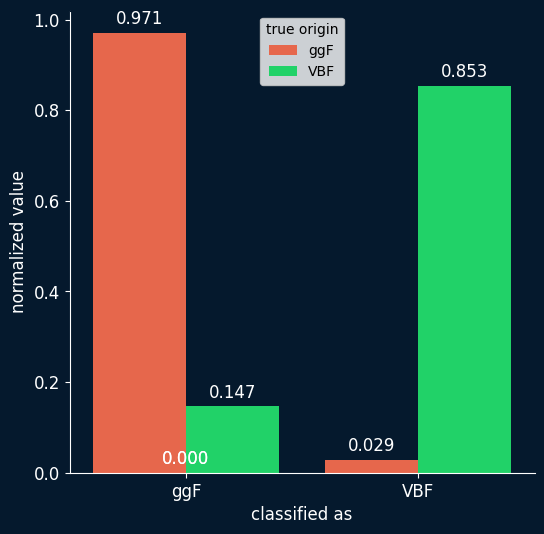

In [11]:
plot_confusion_barras(matriz)

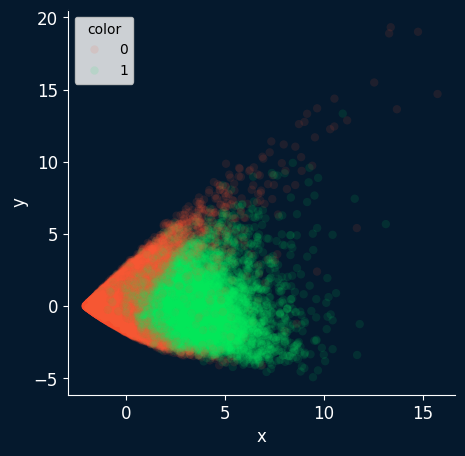

In [12]:
plot_pca_2D(model, 
            df_X.sample(100000, random_state=123), 
            df_y.sample(100000, random_state=123))

In [13]:
y_pred_all = model.predict(X_test)>0.5

18868/18868 [==============================] - 16s 823us/step


In [14]:
y_pred = pd.DataFrame(y_pred_all).sample(100000, random_state=123)

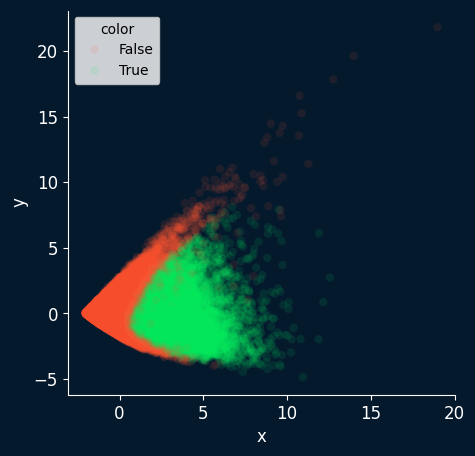

In [15]:
plot_pca_2D(model, 
            pd.DataFrame(X_test.reshape((X_test.shape[0], 6))).sample(100000, random_state=123),
            y_pred)

# AQUI HAGO EL CORTE SOBRE 0.9TeV

In [ ]:
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
X_test, y_test = X_metrico, y_metrico 

In [19]:
X_test

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e
486505,1716.524536,6.421068,81658.984375,3.846909e+06,58792.527344,1.963670e+05
545715,211.995041,3.773266,31825.742188,3.504942e+05,30883.496094,3.893392e+04
629614,1557.994751,7.001796,66716.914062,5.107133e+05,33074.960938,1.192032e+06
1408708,64.160530,0.775761,34539.128906,3.867676e+04,34430.359375,3.692397e+04
583150,73.622955,1.573788,33560.046875,3.658980e+04,31116.775391,5.704566e+04
...,...,...,...,...,...,...
335193,1593.935669,3.654691,298280.593750,8.977612e+05,211806.250000,7.162924e+05
409404,294.300751,1.506423,241128.421875,2.088970e+06,69611.265625,1.425810e+05
1120956,204.654114,3.434795,39726.343750,2.238646e+05,35203.738281,5.578423e+04
1255442,257.687988,0.911607,137808.546875,1.440683e+05,99460.703125,1.791466e+05


In [20]:
X_val

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e
1496675,70.038971,0.111464,42471.859375,4.305344e+04,32429.646484,3.298622e+04
441994,149.992828,2.188928,71264.023438,7.257539e+04,43758.550781,1.774429e+05
786110,132.766708,0.845791,71584.398438,7.569528e+04,52166.742188,9.286408e+04
541852,350.493958,3.686604,82263.781250,1.854304e+05,36864.882812,1.741401e+05
1270972,119.778481,2.171048,36404.968750,9.074698e+04,35920.820312,4.306255e+04
...,...,...,...,...,...,...
9460,1726.495605,5.031024,223499.328125,2.289997e+06,87262.109375,3.327513e+05
1594869,312.131775,0.883416,152417.796875,2.478996e+05,132648.250000,1.355016e+05
11593,1934.757690,3.994384,328765.250000,4.161357e+05,201593.609375,2.702636e+06
1738265,163.567795,2.120286,83518.476562,1.348800e+05,44839.105469,7.321388e+04


In [25]:
# funcion que voy a usar para la clasificacion
# estop se va a aplicar a cada fila
def clasificacion_after(pred_VBF_modelo, pred_VBF_mjj):
    # si está por arriba de 0.9TeV, entonces es VBF
    if pred_VBF_mjj == 1:
        return 1
    # en otro caso mantengo la predicción, puede ser VBF o ggF
    else:
        return pred_VBF_modelo

# función que me entrega una predicción en base al corte original de ML y al corte en 0.9TeV
def aplicar_clasificacion_despues(modelo, df_x):
    # creo un df vacío
    df_comprobar = pd.DataFrame()
    
    # pongo la predicción del modelo en el df
    df_comprobar['pred_VBF_modelo'] = modelo.predict(df_x)[:, 0]
    
    # pongo la predicción del filtro 0.9TeV en el df
    filtro_mjj = df_x["mjj"] >= 900
    df_comprobar['pred_VBF_mjj'] = np.where(filtro_mjj, 1, 0)
    
    # aplico la función que mostré antes para obtener la predicción final
    pred_VBF_modelo_y_mjj = df_comprobar.apply(lambda fila: clasificacion_after(fila['pred_VBF_modelo'], 
                                                                        fila['pred_VBF_mjj']), axis=1)
    
    # entrego la predicción final
    return pred_VBF_modelo_y_mjj

pred_VBF_modelo_y_mjj = aplicar_clasificacion_despues(model, X_test)
pred_VBF_modelo_y_mjj

18868/18868 [==============================] - 17s 884us/step


0         1.00000
1         0.66472
2         1.00000
3         0.00000
4         0.00000
           ...   
603768    1.00000
603769    0.66472
603770    0.66472
603771    0.00000
603772    0.00000
Length: 603773, dtype: float64

In [26]:
y_pred = pred_VBF_modelo_y_mjj.to_numpy()
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

,0,1
0,142917,4338
1,241813,214705


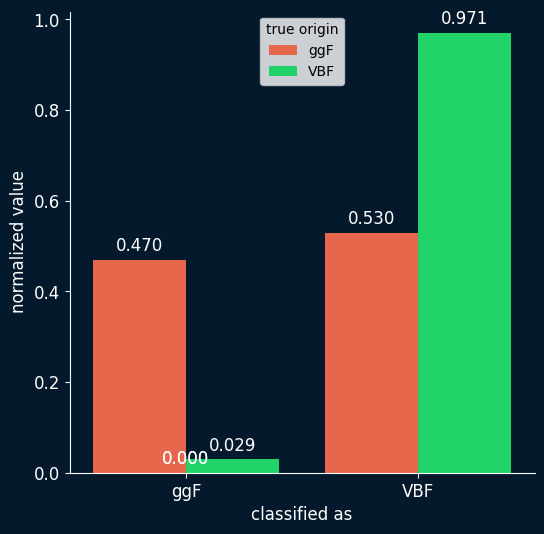

In [27]:
plot_confusion_barras(matriz)

In [20]:
precision(model, X_test, y_test)

3755/3755 [==============================] - 3s 779us/step
Precisión del modelo: 11.15%


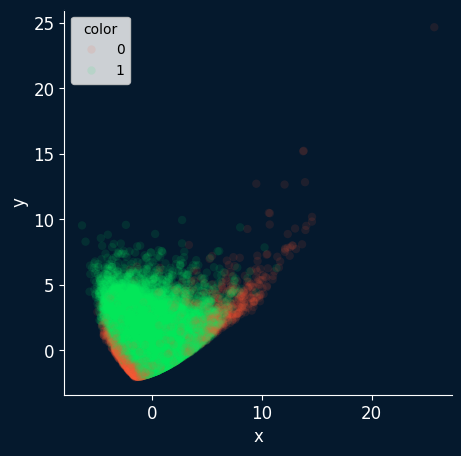

In [21]:
plot_pca_2D(model, 
            df_X.sample(100000, random_state=123), 
            df_y.sample(100000, random_state=123))